### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

#### 1. когда совершил первую покупку (сколько прошло с момента регистрации до момента покупки)

![ab_split](payments1.png "Payments2")

#### 2. по психотипам

![ab_split](psycho.png "Psycho")

#### 3. по платежам

![ab_split](payments.png "Payments")

#### 4. По эффективности взаимодействия (uplift)

![ab_split](uplift.png "Uplift")

#### 5. по интересам

![ab_split](interests.png "Interests")

И еще 100500 вариантов сегментирования, которое может быть полезно. 

Для чего полезно?

1. понимание аудитории, способность описать основные группы пользователей и их интересы
2. выявление сегментов с максимальной монетизацией
3. выбор маркетинговой стратегии
4. налаживание эффективного взаимодействия с пользователями

#### Пример из жизни (новостной портал)

Представим, что мы - компания-агрегатор новостей (новостной портал).

У нас есть:

1. читатели
2. новости

Для каждого пользователя мы можем за какой-то период (например, 1 день) достать из базы данных список прочитанных им новостей.

Для каждой новости мы можем вытащить текст и метаинформацию.

### Задача #1: нужно построить модель прогнозирования оттока - это наша downstream-задача. 

Нам нужны:

1. векторное представление пользователя
2. сегменты, описывающие интересы пользователя

p.s. в контексте нашей задачи - это одно и то же

### С чего начнем?

С векторного представления и сегментов новостей!

Есть два очевидных варианта как это сделать:

1. многоклассовая классификация
2. кластеризация документов с последующей попыткой их (кластера) интерпретировать

Проблема:

1. для классификации нам нужно сначала разметить новости - привлечение ручного труда

### Задача тематического моделирования

#### Неформально!

- на свете бывают темы (заранее неизвестные), которые отражают то, о чём могут быть части документа;
- каждая тема – это распределение вероятностей на словах, т.е. мешок слов, из которого можно с разной вероятностью вытащить разные слова;
- каждый документ – это смесь тем, т.е. распределение вероятностей на темах, кубик, который можно кинуть;
- процесс порождения каждого слова состоит в том, чтобы сначала выбрать тему по распределению, соответствующему документу, а затем выбрать слово из распределения, соответствующего этой теме.

Вероятностные модели удобно понимать и представлять в виде порождающих процессов (generative processes), когда мы последовательно описываем, как порождается одна единица данных, вводя по ходу дела все вероятностные предположения, которые мы в этой модели делаем. Соответственно, порождающий процесс для LDA должен последовательно описывать, как мы порождаем каждое слово каждого документа. И вот как это происходит (здесь и далее я буду предполагать, что длина каждого документа задана – её тоже можно добавить в модель, но обычно это ничего нового не даёт):

1. для каждой темы t выбираем вектор phi_t - распределение слов в теме

2. для каждого документа d:

    2.1 выбираем Theta_d - распределение тем в документе
    
    2.2 для каждого из слов документа w:
        2.2.1 выбираем тему z~Theta_d
        2.2.2 выбираем слово w~p(w|z, phi)

![lda](lda_simple.png "LDA")

ист. https://habr.com/ru/company/surfingbird/blog/230103/

#### Чуть более формально

Терминология:

1. документ - коллекция слов 
2. тема - набор токенов (слов), совместно часто встречающихся в документах

Более формально:

1. тема - условное распределение на множестве терминов, p(w|t)
2. тематический профиль документа - условное распределение тем p(t|d)

Вопрос: что же нам дано (в терминах условной вероятности)?

Ответ: условное распределение слов в документах - p(w|d)

Прекрасное объяснение от Воронцова - http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

Тематическая модель позволяет нам получить p(w|t), p(t|d) по известным p(w|d)

![ab_split](tm1.png "TM1")

### ПЕРЕРЫВ ДО 21:02 (МСК)

### Переходим к практике

In [1]:
import pandas as pd

Наши новости

In [18]:
news = pd.read_csv("C:/Users/1/Downloads/materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [5]:
users = pd.read_csv("C:/Users/1/Downloads/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [6]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [9]:
!pip install razdel
!pip install pymorphy2


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     -------------------------------------- 55.5/55.5 kB 192.5 kB/s eta 0:00:00


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 8.2/8.2 MB 327.7 kB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=146838e141611851b7d8e52364ad5cc7098e7463f3b875bc078dd59e2cef99a4
  Stored in directory: c:\users\1\appdata\local\pip\cache\wheels\70\4a\46\1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [10]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [13]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [14]:
with open('C:/Users/1/Downloads/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [15]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [19]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\1\AppData\Local\Temp\ipykernel_14072\2296537027.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 1min 1s


In [20]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 13min 48s


А теперь в 3 строчки обучим нашу модель

In [21]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [22]:
common_dictionary[11]

'взаимодействие'

Все просто - это словарь наших слов

Запускаем обучение

In [23]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 3min 34s
Parser   : 132 ms


In [24]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [25]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(4, 0.26602346), (20, 0.40057594), (21, 0.08744482), (24, 0.22726548)]

In [26]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: рубль суд дело сотрудник nn уголовный проверка
topic_1: год исследование который nn это банк область
topic_2: ребёнок исследование путин который это год nn
topic_3: рейс смерть вицепремьер снять грузия казахстан донбасс
topic_4: год тыс форум праздник оборудование день сайт
topic_5: восток соцсеть подросток су израильский ввс вскоре
topic_6: рак остров век медицина выдать берег болезнь
topic_7: фестиваль конкурс год стать супруг пройти мероприятие
topic_8: россия который nn сша год фонд российский
topic_9: северный южный турция иран корея конструкция турецкий
topic_10: пенсия городской мальчик рассмотрение выборы реформа юрист
topic_11: год это который компания млрд мочь статья
topic_12: взрыв космос атмосферный небо потребность разбираться химия
topic_13: это год который мочь россия свой страна
topic_14: оплата производить вдвое мэр отправляться достопримечательность оплатить
topic_15: рост экономика экономический китай это средний цена
topic_16: обнаружить врач год выяснить 

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [27]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [28]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.931214,0.00000,0.000000,0.039875,0.0,0.0,0.021179,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,4896,0.126911,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.277297,0.000000,0.0,0.0,0.000000
2,4897,0.000000,0.000000,0.00000,0.000000,0.266037,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.400586,0.087447,0.0,0.0,0.227239
3,4898,0.000000,0.046472,0.00000,0.000000,0.075590,0.0,0.0,0.000000,0.0,...,0.161464,0.0,0.192374,0.0,0.0,0.000000,0.000000,0.0,0.0,0.150611
4,4899,0.000000,0.533625,0.04822,0.027371,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.087378


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [29]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [30]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [31]:
doc_dict[293622]

array([0.09948838, 0.        , 0.24625714, 0.        , 0.09170249,
       0.0203615 , 0.09437198, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.13390541, 0.02486402,
       0.        , 0.10923933, 0.15075986, 0.        , 0.        ,
       0.        , 0.01994861, 0.        , 0.        , 0.        ])

In [32]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [33]:
get_user_embedding(user_articles_list)

array([0.12550453, 0.03372887, 0.19390583, 0.        , 0.00440109,
       0.0068786 , 0.        , 0.01581693, 0.1753581 , 0.00427151,
       0.00628225, 0.07452858, 0.        , 0.19741887, 0.        ,
       0.02383304, 0.00167937, 0.05425093, 0.        , 0.01765555,
       0.01545906, 0.        , 0.03148524, 0.00316133, 0.00219183])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [82]:
#users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [88]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость nn читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри nn позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать бара

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [34]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.025522,0.137366,0.127575,0.030566,0.137187,0.003394,0.015729,0.030497,0.075469,...,0.000000,0.021808,0.095528,0.015608,0.003773,0.064603,0.003325,0.040147,0.0,0.003906
1,u108690,0.086445,0.070504,0.127496,0.005134,0.012131,0.003226,0.001896,0.009375,0.176144,...,0.012595,0.010285,0.054554,0.001786,0.004999,0.152781,0.000000,0.010009,0.0,0.000000
2,u108339,0.102713,0.095153,0.045180,0.000000,0.035355,0.003506,0.002917,0.012613,0.177617,...,0.004023,0.050732,0.093905,0.000000,0.012550,0.048170,0.000000,0.011278,0.0,0.002175


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [35]:
target = pd.read_csv("C:/Users/1/Downloads/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [36]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.025522,0.137366,0.127575,0.030566,0.137187,0.003394,0.015729,0.030497,0.075469,...,0.021808,0.095528,0.015608,0.003773,0.064603,0.003325,0.040147,0.0,0.003906,0
1,u108690,0.086445,0.070504,0.127496,0.005134,0.012131,0.003226,0.001896,0.009375,0.176144,...,0.010285,0.054554,0.001786,0.004999,0.152781,0.000000,0.010009,0.0,0.000000,1
2,u108339,0.102713,0.095153,0.045180,0.000000,0.035355,0.003506,0.002917,0.012613,0.177617,...,0.050732,0.093905,0.000000,0.012550,0.048170,0.000000,0.011278,0.0,0.002175,1


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [38]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [39]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [40]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.12326096, 0.09850651, 0.38610406, 0.32159142, 0.06762543,
       0.06070603, 0.24881976, 0.05667332, 0.03117411, 0.15205918])

In [41]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [42]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.520562, F-Score=nan, Precision=0.000, Recall=0.000


C:\Users\1\AppData\Local\Temp\ipykernel_14072\3063505166.py:2: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1754    1]
 [ 245    0]]


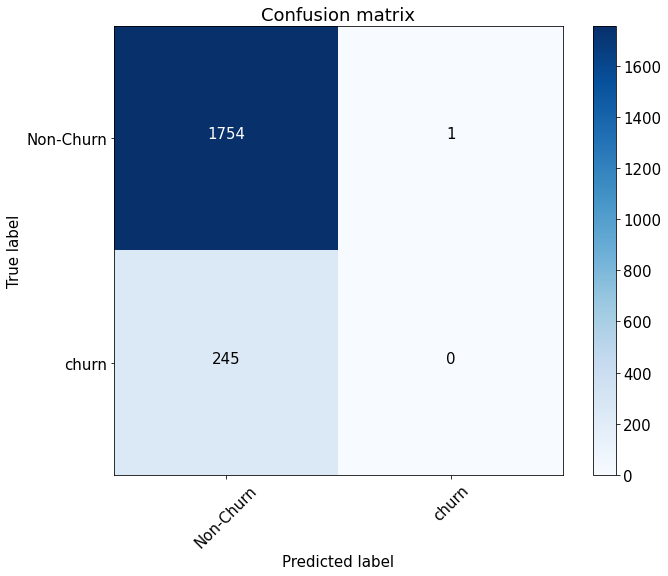

In [46]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
import itertools
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [45]:
roc_auc_score(y_test, preds)

0.9196581196581197

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

### Задача 1. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [51]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [52]:
get_user_embedding(user_articles_list)

array([0.        , 0.02464375, 0.18723309, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.12014553, 0.        ,
       0.        , 0.02869395, 0.        , 0.21543517, 0.        ,
       0.        , 0.        , 0.02291388, 0.        , 0.        ,
       0.00563237, 0.        , 0.01541659, 0.        , 0.        ])

In [53]:
user_embeddings1 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings1.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings1['uid'] = users['uid'].values
user_embeddings1 = user_embeddings1[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.141943,0.071630,0.0,0.045851,0.0,0.0,0.0,0.059343,...,0.000000,0.000000,0.109145,0.0,0.0,0.000000,0.0,0.014395,0.0,0.0
1,u108690,0.024395,0.076405,0.143725,0.0,0.000000,0.0,0.0,0.0,0.195403,...,0.006474,0.007273,0.062446,0.0,0.0,0.197456,0.0,0.000000,0.0,0.0
2,u108339,0.069890,0.080408,0.036539,0.0,0.018121,0.0,0.0,0.0,0.195543,...,0.000000,0.040900,0.072158,0.0,0.0,0.045364,0.0,0.005932,0.0,0.0


In [54]:
X1 = pd.merge(user_embeddings1, target, 'left')
X1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.141943,0.071630,0.0,0.045851,0.0,0.0,0.0,0.059343,...,0.000000,0.109145,0.0,0.0,0.000000,0.0,0.014395,0.0,0.0,0
1,u108690,0.024395,0.076405,0.143725,0.0,0.000000,0.0,0.0,0.0,0.195403,...,0.007273,0.062446,0.0,0.0,0.197456,0.0,0.000000,0.0,0.0,1
2,u108339,0.069890,0.080408,0.036539,0.0,0.018121,0.0,0.0,0.0,0.195543,...,0.040900,0.072158,0.0,0.0,0.045364,0.0,0.005932,0.0,0.0,1


In [55]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1[['topic_{}'.format(i) for i in range(25)]], 
                                                    X1['churn'], random_state=0)

In [56]:
logreg_2 = LogisticRegression()
#обучим 
logreg_2.fit(X_train1, y_train1)

LogisticRegression()

In [57]:
#наши прогнозы для тестовой выборки
preds_2 = logreg_2.predict_proba(X_test1)[:, 1]
preds_2[:10]

array([0.08522197, 0.03396064, 0.47567854, 0.25590772, 0.03900503,
       0.06251309, 0.13752734, 0.01503874, 0.04490124, 0.23344613])

Перед расчетом метрик подготовим базу для таблицы сравнения метрик:

In [58]:
metric_list=[[i] for i in [thresholds[ix], fscore[ix], precision[ix], recall[ix]]]
metric_list

[[0.5205622983902656], [nan], [0.0], [0.0]]

In [60]:
precision, recall, thresholds = precision_recall_curve(y_test1, preds_2)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.278454, F-Score=0.742, Precision=0.693, Recall=0.800


In [61]:
median_metrcs=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]
for i in range(len(metric_list)):
    metric_list[i].append(median_metrcs[i])
metric_list

[[0.5205622983902656, 0.2784536411089421],
 [nan, 0.7424242424242425],
 [0.0, 0.6925795053003534],
 [0.0, 0.8]]

Confusion matrix, without normalization
[[1668   87]
 [  50  195]]


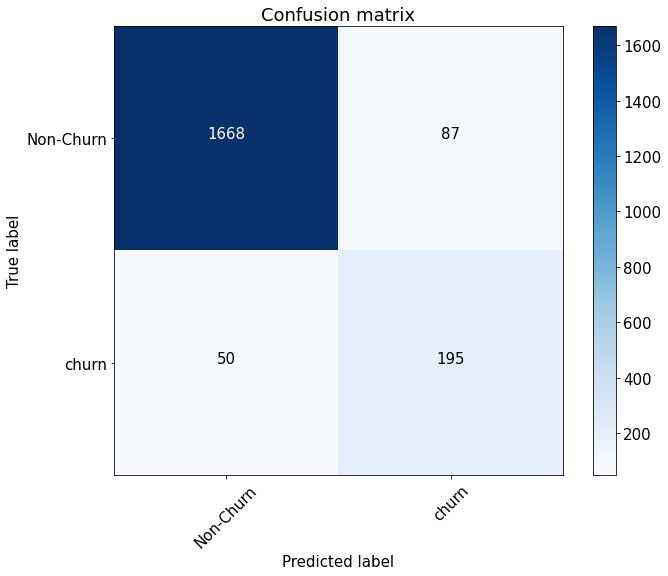

In [63]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test1, preds_2>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [64]:
roc_auc_score(y_test1, preds_2)

0.9598674341531483

### Задача 2. Повторить п.2, но используя уже не медиану, а max

In [65]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [66]:
get_user_embedding_max(user_articles_list)

array([0.54137492, 0.09102336, 0.37901589, 0.        , 0.01461824,
       0.04127158, 0.        , 0.09490161, 0.39403117, 0.02562909,
       0.03769352, 0.23657908, 0.        , 0.44529974, 0.        ,
       0.08594954, 0.0100762 , 0.23010196, 0.        , 0.06705008,
       0.05318836, 0.        , 0.09866279, 0.018968  , 0.01315095])

In [67]:
user_embeddings2 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings2.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings2['uid'] = users['uid'].values
user_embeddings2 = user_embeddings2[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.099488,0.342976,0.375932,0.161273,0.473944,0.020362,0.094372,0.182983,0.208048,...,0.000000,0.109239,0.204118,0.093651,0.022640,0.339734,0.019949,0.125478,0.0,0.023438
1,u108690,0.387264,0.161217,0.273234,0.018218,0.059739,0.019357,0.011377,0.033114,0.251130,...,0.037078,0.026304,0.105335,0.010717,0.029996,0.273203,0.000000,0.060054,0.0,0.000000
2,u108339,0.221120,0.216835,0.123421,0.000000,0.124225,0.021034,0.017505,0.075675,0.283111,...,0.024140,0.131269,0.279617,0.000000,0.075302,0.128850,0.000000,0.035164,0.0,0.013047


In [68]:
X2 = pd.merge(user_embeddings2, target, 'left')
X2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.099488,0.342976,0.375932,0.161273,0.473944,0.020362,0.094372,0.182983,0.208048,...,0.109239,0.204118,0.093651,0.022640,0.339734,0.019949,0.125478,0.0,0.023438,0
1,u108690,0.387264,0.161217,0.273234,0.018218,0.059739,0.019357,0.011377,0.033114,0.251130,...,0.026304,0.105335,0.010717,0.029996,0.273203,0.000000,0.060054,0.0,0.000000,1
2,u108339,0.221120,0.216835,0.123421,0.000000,0.124225,0.021034,0.017505,0.075675,0.283111,...,0.131269,0.279617,0.000000,0.075302,0.128850,0.000000,0.035164,0.0,0.013047,1


In [69]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2[['topic_{}'.format(i) for i in range(25)]], 
                                                    X2['churn'], random_state=0)

In [70]:
logreg_3 = LogisticRegression()
#обучим 
logreg_3.fit(X_train2, y_train2)

LogisticRegression()

In [71]:
#наши прогнозы для тестовой выборки
preds_3 = logreg_3.predict_proba(X_test2)[:, 1]
preds_3[:10]

array([0.05168125, 0.0101918 , 0.64149566, 0.02518047, 0.01145165,
       0.00337532, 0.02585149, 0.04287728, 0.0021054 , 0.35377323])

In [73]:
precision, recall, thresholds = precision_recall_curve(y_test2, preds_3)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.351786, F-Score=0.786, Precision=0.785, Recall=0.788


In [74]:
max_metrcs=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]
for i in range(len(metric_list)):
    metric_list[i].append(max_metrcs[i])
metric_list

[[0.5205622983902656, 0.2784536411089421, 0.3517858942722409],
 [nan, 0.7424242424242425, 0.7861507128309573],
 [0.0, 0.6925795053003534, 0.7845528455284553],
 [0.0, 0.8, 0.7877551020408163]]

Confusion matrix, without normalization
[[1702   53]
 [  53  192]]


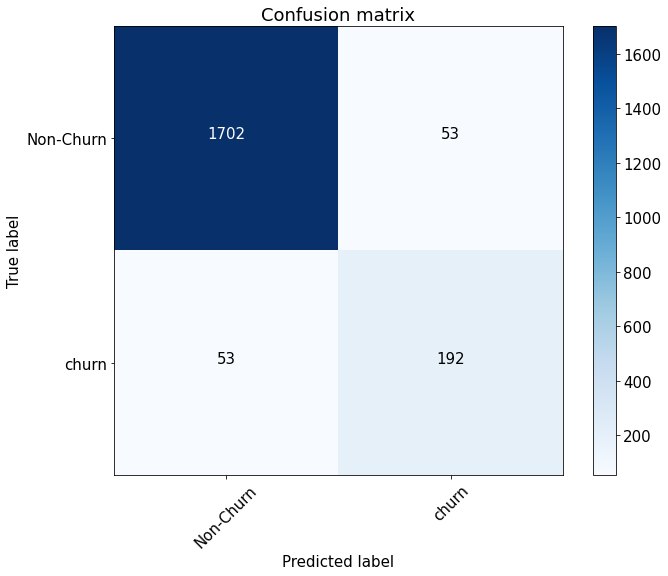

In [75]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test2, preds_3>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [76]:
roc_auc_score(y_test2, preds_3)

0.9716588173731031

### Задача 4. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [78]:
metric_df=pd.DataFrame(
    metric_list, columns=['mean','median','max'], index=['Treshhold','F-score','Precision', 'Recall']
).append(pd.DataFrame(
                    [[roc_auc_score(y_test, preds),roc_auc_score(y_test1, preds_2),roc_auc_score(y_test2, preds_3)]],
    columns=['mean','median','max'],
    index=['ROC-AUC']))
metric_df

C:\Users\1\AppData\Local\Temp\ipykernel_14072\3775741968.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df=pd.DataFrame(


,mean,median,max
Treshhold,0.520562,0.278454,0.351786
F-score,NaN,0.742424,0.786151
Precision,0.000000,0.692580,0.784553
Recall,0.000000,0.800000,0.787755
ROC-AUC,0.919658,0.959867,0.971659


Как видно из таблицы, наиболее эффективным оказался метод с использованием медианы для получения эмбеддинга пользователя, т.к. мы получаем более разреженный вектор заинтересованности пользователя, в следствии того, что в отличии от среднего и максимального значения, медиана чаще будет равна нулю, на тех темах статей, оторые редко появляются в векторе статей читаемых пользователем. То есть интересы пользователя будут выражены наиболее явно.